# Time series tests
In this notebook we performed tests on the synthetic generation of time series. It is **not a user guide**, it is meant to give details into what tests we performed and how we did them.

In [1]:
# Import libraries
import os
import sys
import pandas as pd
import numpy as np

from sdv.datasets.local import load_csvs

# Get the current file's directory
current_dir = os.path.dirname(os.path.abspath(""))

# Construct the path to the module
module_path = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(module_path)

# Import TimeSeriesGeneration
from src.TimeSeriesGeneration.ts_generator import *
from src.TimeSeriesGeneration.ts_similarity import *
from src.TimeSeriesGeneration.data_processing import *

DATA_PATH = os.path.join(module_path, "data")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Train model on whole dataset

In [2]:
# Load dataframe
datasets = load_csvs(folder_name=DATA_PATH)
df = datasets["energy_dataset"]
preprocess = DataProcessor(
    df=df
)

In [5]:
# Preprocess data and get metadata
data_processor = DataProcessor(df, obs_limit=1000, interpolate=True, drop_na_cols = True)
# the name of the time column is time in this df and all columns can be used as identifiers in long format
df_real = data_processor.convert_to_long_format(time_columns='time', verbose=False)
metadata = data_processor.get_metadata_long_df(identifier='variable', time_column='time', datetime_format='%Y-%m-%d %H:%M:%S')

In [6]:
ts_gen = TSGenerator(
    df=df_real,
    metadata=metadata,
    verbose=True
)

In [7]:
ts_gen.train(n_epochs=100)

Epoch 100 | Loss -60.64765930175781: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


In [8]:
df_synth = ts_gen.sample(n_samples=10)

100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


In [10]:
ts_sim = TSSimilarityCheck(
    df_real=df_real,
    df_synth=df_synth,
    metadata=metadata
)

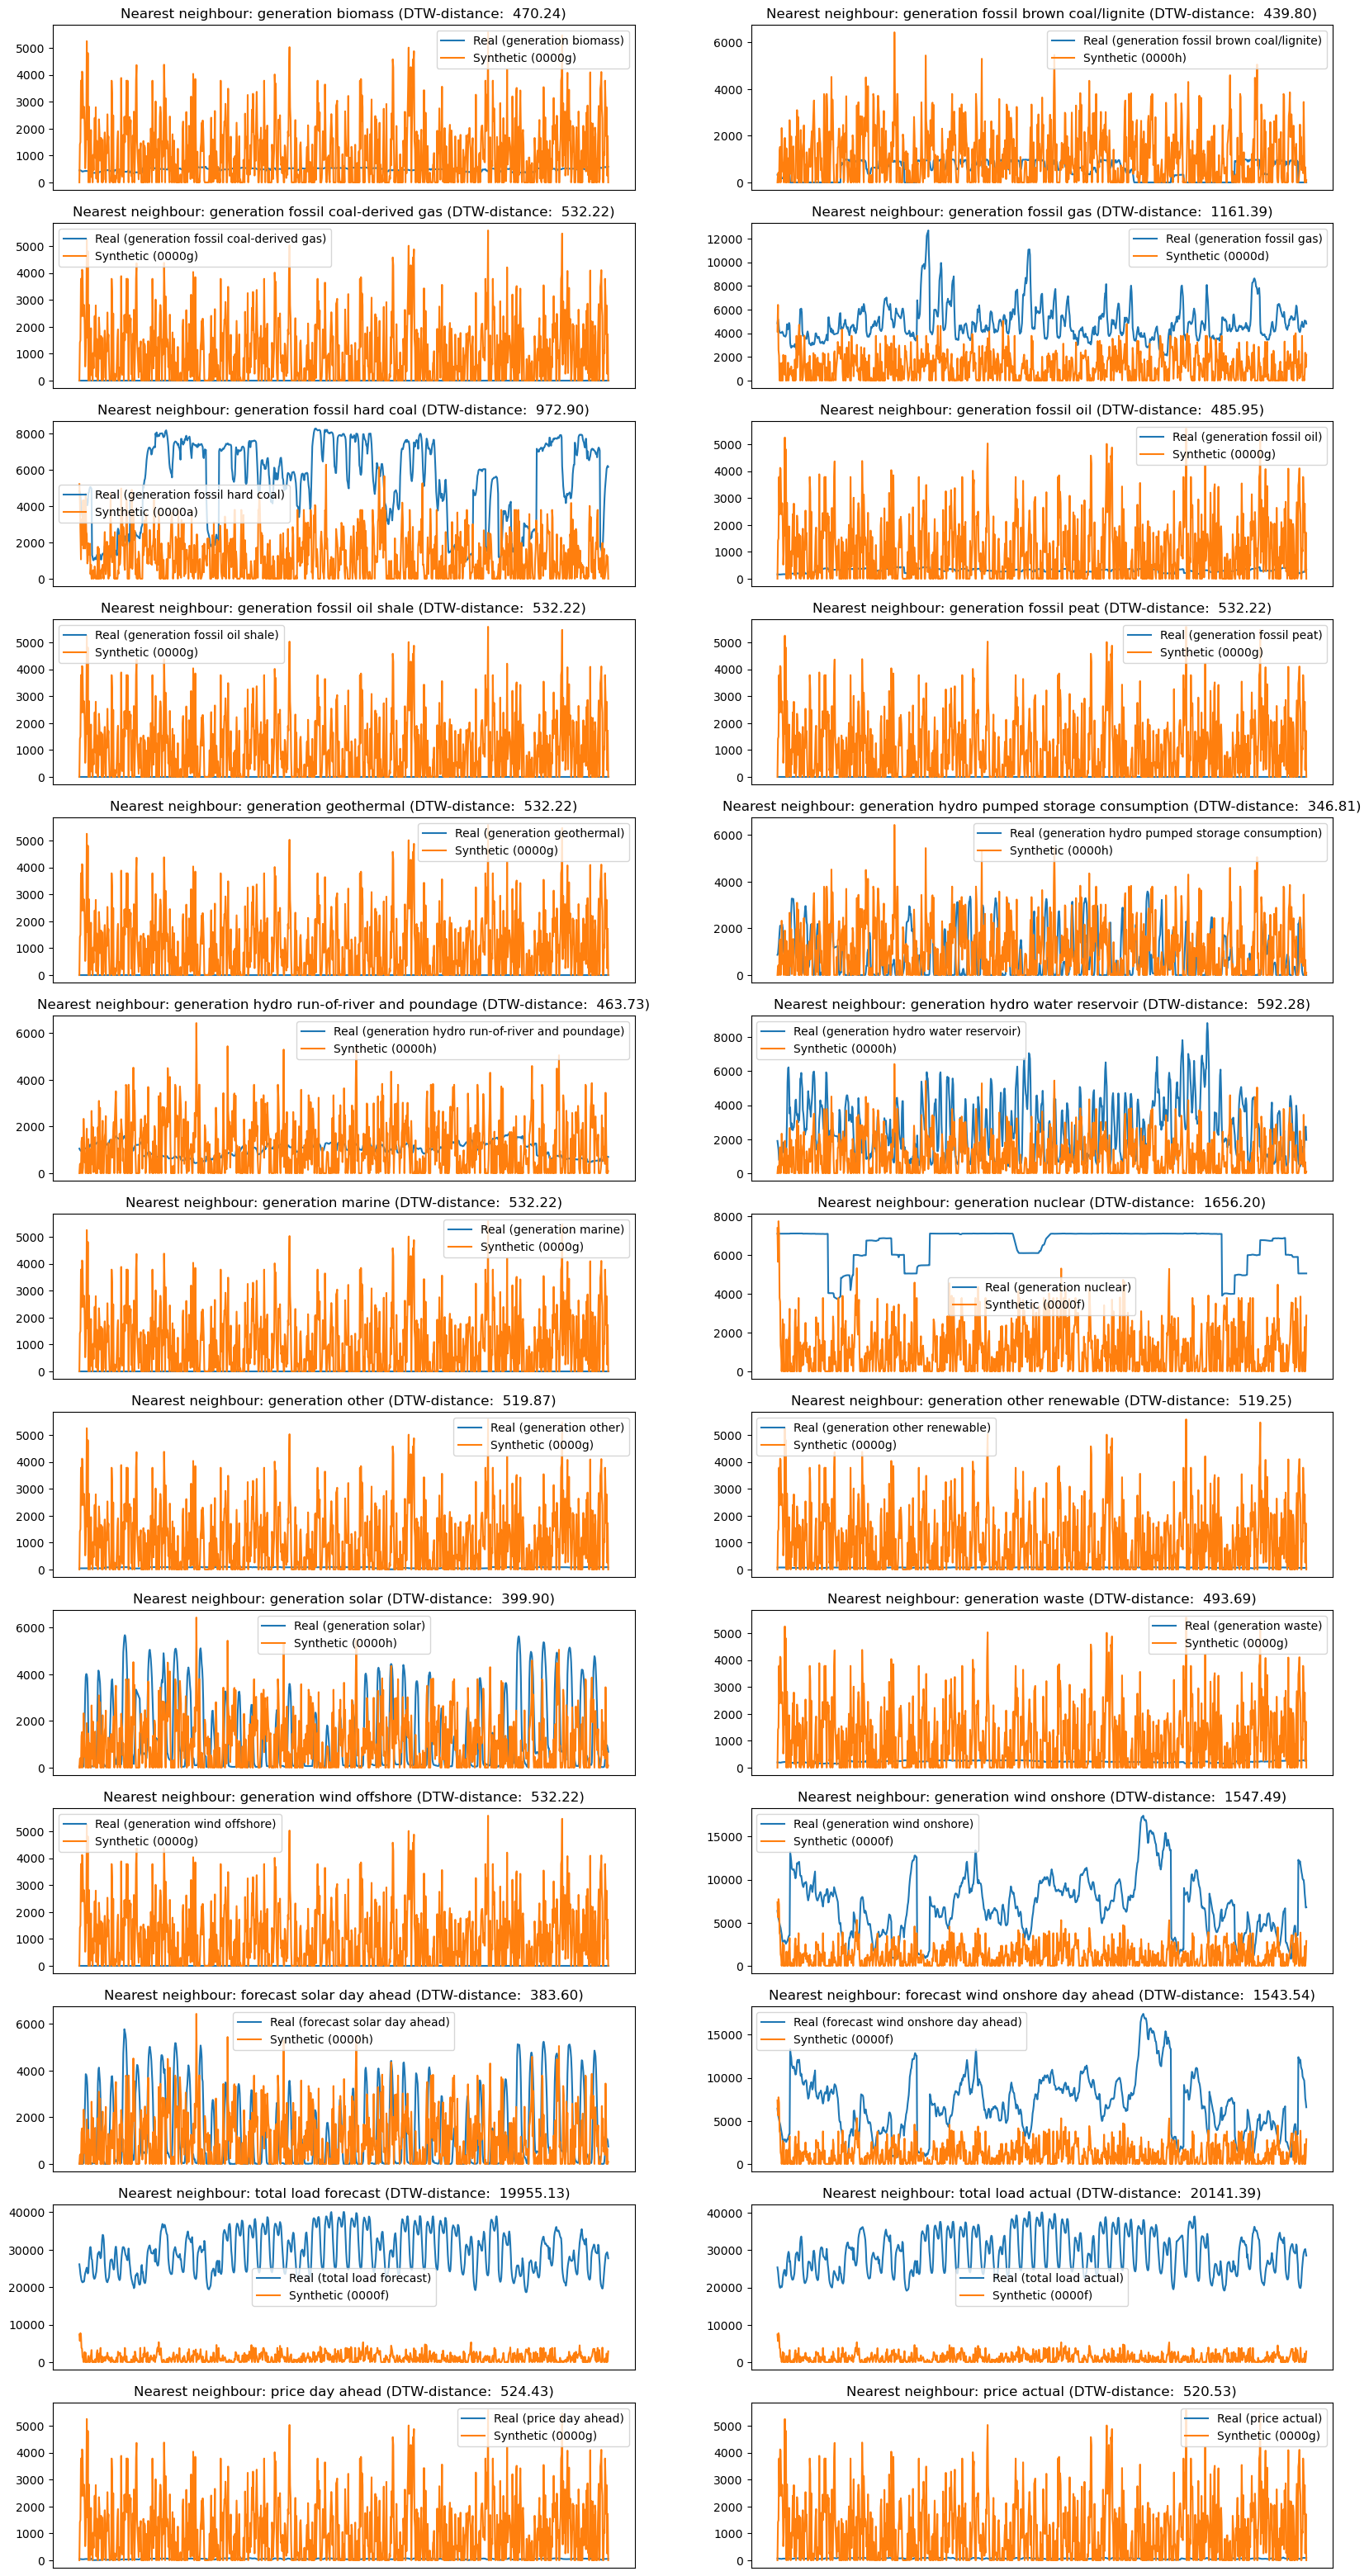

In [11]:
ts_sim.plot_nearest_neighbours(figsize = (20,40))

## Training on a single TS

In [17]:
def train_single_TS(df_real, metadata, identifier, ts_name, figsize = (20, 5), n_samples = 5, n_epochs = 100, verbose = True):
    y_real = df_real[df_real[identifier] == ts_name]

    ts_gen_biomass = TSGenerator(
        df=y_real,
        metadata=metadata,
        verbose=verbose
    )

    ts_gen_biomass.train(n_epochs=n_epochs)
    
    df_synth = ts_gen_biomass.sample(n_samples=n_samples)

    ts_sim_biomass = TSSimilarityCheck(
        df_real=y_real,
        df_synth=df_synth,
        metadata=metadata
    )
    ts_sim_biomass.plot_nearest_neighbours(figsize = figsize)

    return df_synth

#### Biomass

Pooled DTW: 470\
Single DTW: 14

Epoch 100 | Loss -1521.479248046875: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]
100%|██████████| 5/5 [00:32<00:00,  6.40s/it]


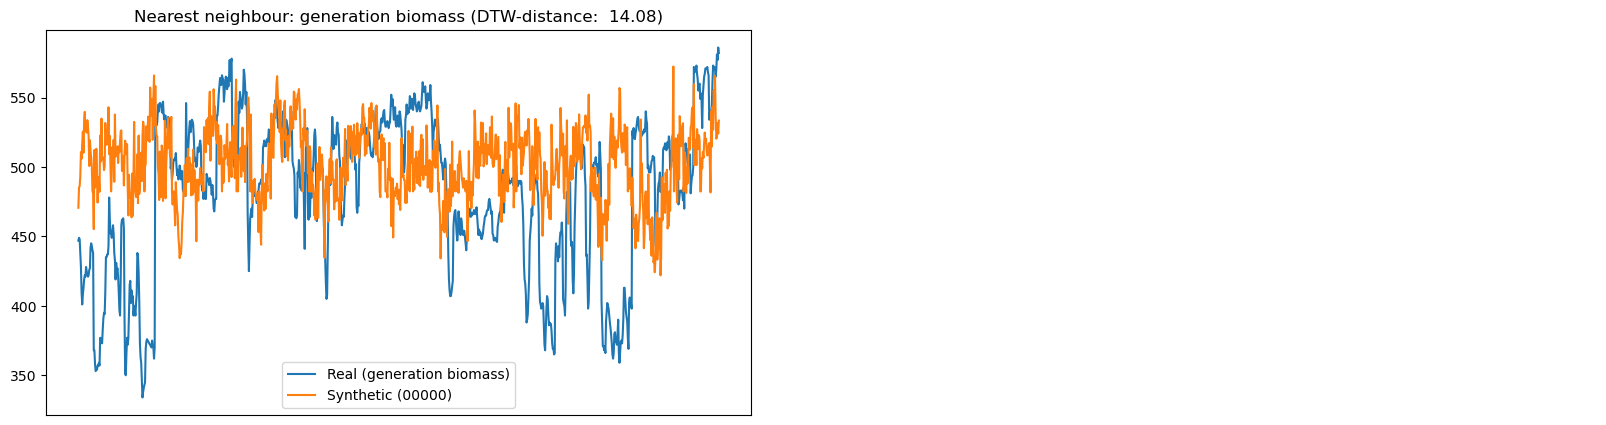

In [18]:
biomass = train_single_TS(df_real, metadata, identifier="variable", ts_name="generation biomass", n_epochs = 100, n_samples = 5, verbose = True)

**Comment:** By training only a model on a single time series we are able to reproduce single time series much better. The DTW-distance is being reduced from 470 to 14!

#### Periodic TS (forecast solar day ahead)

Pooled DTW: 383\
Single DTW: 363

Epoch 1000 | Loss -2247.03173828125: 100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]
100%|██████████| 5/5 [00:31<00:00,  6.32s/it]


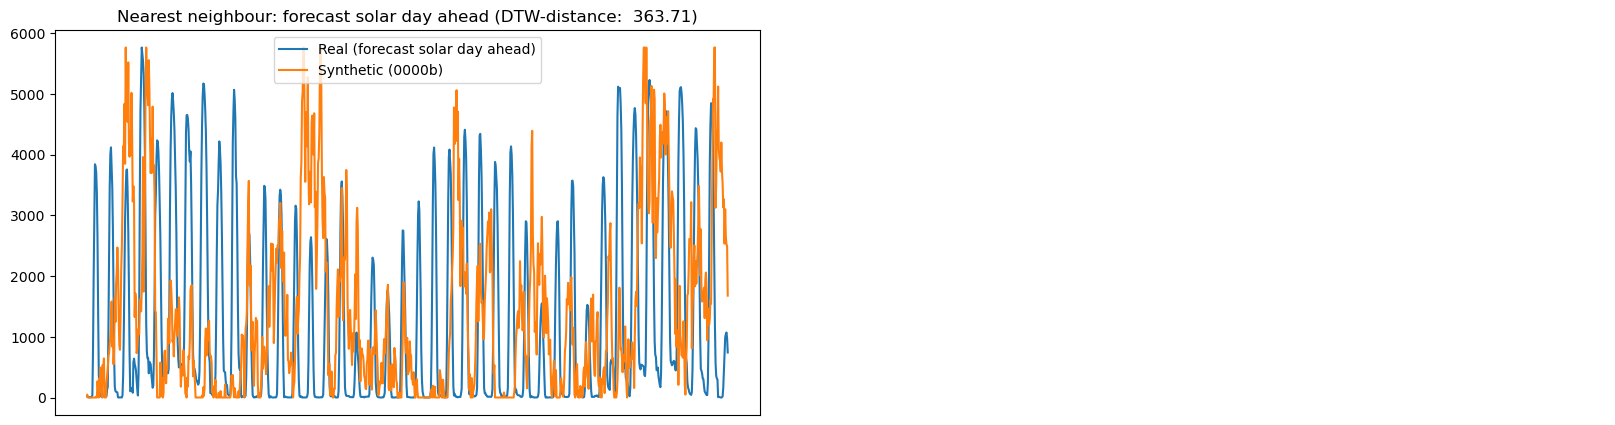

In [20]:
forecast_solar = train_single_TS(df_real, metadata, identifier="variable", ts_name="forecast solar day ahead", n_epochs = 1000, n_samples = 5, verbose = True)

**Comment:** This is worse than training with a lot of different TS!

#### AR-process: Generation wind onshore

Pooled DTW: 1547\
Single DTW: 784

Epoch 1000 | Loss -2427.78515625: 100%|██████████| 1000/1000 [02:51<00:00,  5.83it/s]   
100%|██████████| 5/5 [00:31<00:00,  6.35s/it]


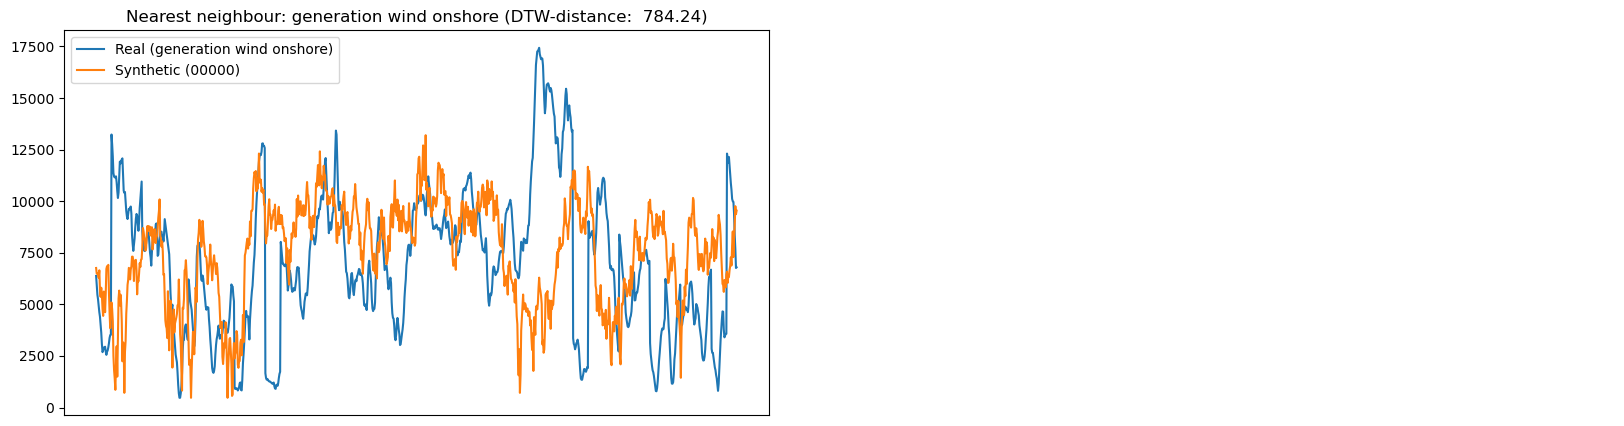

In [21]:
generation_wind = train_single_TS(df_real, metadata, identifier="variable", ts_name="generation wind onshore", n_epochs = 1000, n_samples = 5, verbose = True)

## Evaluation of PAR on single fake TS

Types of TS:
- Exponential Trend
- White Noise
- AR(1)-process
- Constant TS
- Square

In [22]:
# Create dataset with all types of TS in a long format
t_vals = np.arange(1,1001, step = 1)

# Exponential trend: y(t) = e^0.006t + e_t. e_t ~ N(0, 5)
e_t = np.random.normal(0, 5, len(t_vals))
y_exp = np.exp(0.006*t_vals) + e_t
y_exp = y_exp.reshape((-1, 1))

# White noise around a constant: y(t) = 100 + e_t. e_t ~ N(0, 5)
e_t = np.random.normal(100, 5, (len(t_vals), 1))
y_white_noise = e_t.reshape((-1, 1))

# AR(1)-process: y(t) = gamma*y(t-1) + e_t. y_0 = 100, e_t ~ N(0, 5)
e_t = np.random.normal(0, 5, len(t_vals))
y_0 = 0
gamma = 0.8
y_ar = np.array([y_0])
for i in t_vals[:-1]:
    e_t = np.random.normal(0, 5)
    y_t = gamma*y_ar[i-1] + e_t
    y_ar = np.append(y_ar, y_t)
y_ar = y_ar + 100
y_ar = y_ar.reshape((-1, 1))

# Constant TS: y(t) = 100
y_const = np.array([100]*len(t_vals)).reshape((-1, 1))

# Square wave: y(t) = 100 + I(t%200 < 100)*100
y_square = np.array([200 if (t-1)%200 < 100 else 100 for t in t_vals]).reshape((-1, 1))



# Create dataframe
df_ts = pd.DataFrame(np.concatenate((t_vals.reshape(-1, 1), y_exp, y_white_noise, y_ar, y_const, y_square), axis = 1), columns=["time", "exponential", "white_noise", "AR", "constant", "square"])
df_ts

,time,exponential,white_noise,AR,constant,square
0,1.0,6.400220,101.644458,100.000000,100.0,200.0
1,2.0,-5.343347,113.593595,94.944465,100.0,200.0
2,3.0,6.765818,108.045826,91.396726,100.0,200.0
3,4.0,10.554914,106.573583,91.736740,100.0,200.0
4,5.0,-4.261872,96.638391,95.568112,100.0,200.0
...,...,...,...,...,...,...
995,996.0,395.827958,97.603340,92.271385,100.0,100.0
996,997.0,404.584071,102.698455,97.058256,100.0,100.0
997,998.0,409.629418,101.842741,86.664178,100.0,100.0
998,999.0,397.103587,112.524425,87.879663,100.0,100.0


In [24]:
data_processor = DataProcessor(df_ts)
# the name of the time column is time in this df and all columns can be used as identifiers in long format
df_ts_long = data_processor.convert_to_long_format(time_columns='time', verbose=False)
metadata_ts = data_processor.get_metadata_long_df(identifier='variable', time_column='time')

### Exponential

Epoch 1000 | Loss -2820.5322265625: 100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s] 
100%|██████████| 5/5 [00:33<00:00,  6.74s/it]


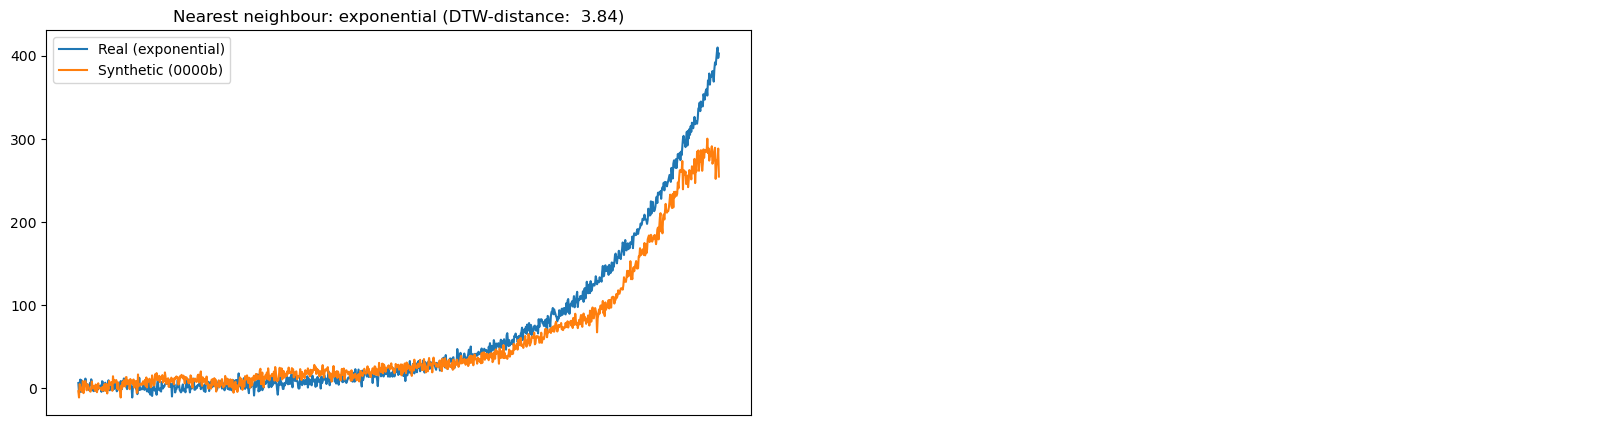

In [33]:
exponential_synth = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="exponential", n_epochs = 1000, n_samples = 5, verbose = True)

**Comment:** PAR performs quite well, though not perfectly. Especially the end of the series is not exponential anymore.

### White Noise

Epoch 1000 | Loss -1854.4078369140625: 100%|██████████| 1000/1000 [02:53<00:00,  5.76it/s]
100%|██████████| 5/5 [00:33<00:00,  6.76s/it]


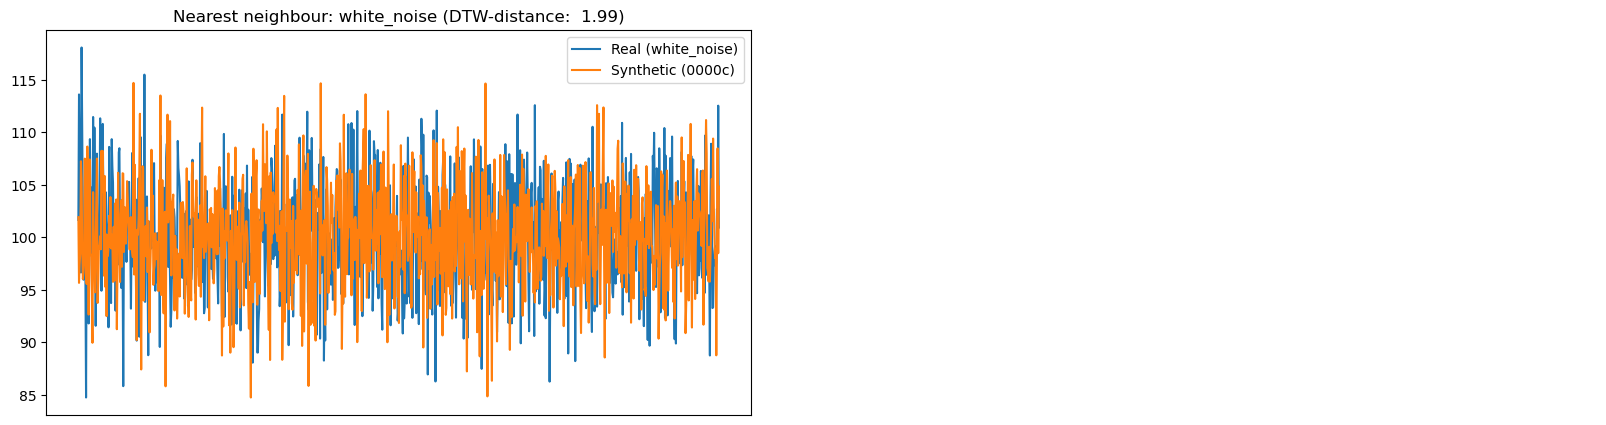

In [29]:
white_noise_synth = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="white_noise", n_epochs = 1000, n_samples = 5, verbose = True)

**Comment:** PAR is able to model white noise quite well, though one can notice how the model still tries to fit an AR-like model to it, despite the real TS being white noise.

### AR(1)

Epoch 1000 | Loss -2122.085693359375: 100%|██████████| 1000/1000 [02:59<00:00,  5.57it/s]
100%|██████████| 5/5 [00:32<00:00,  6.60s/it]


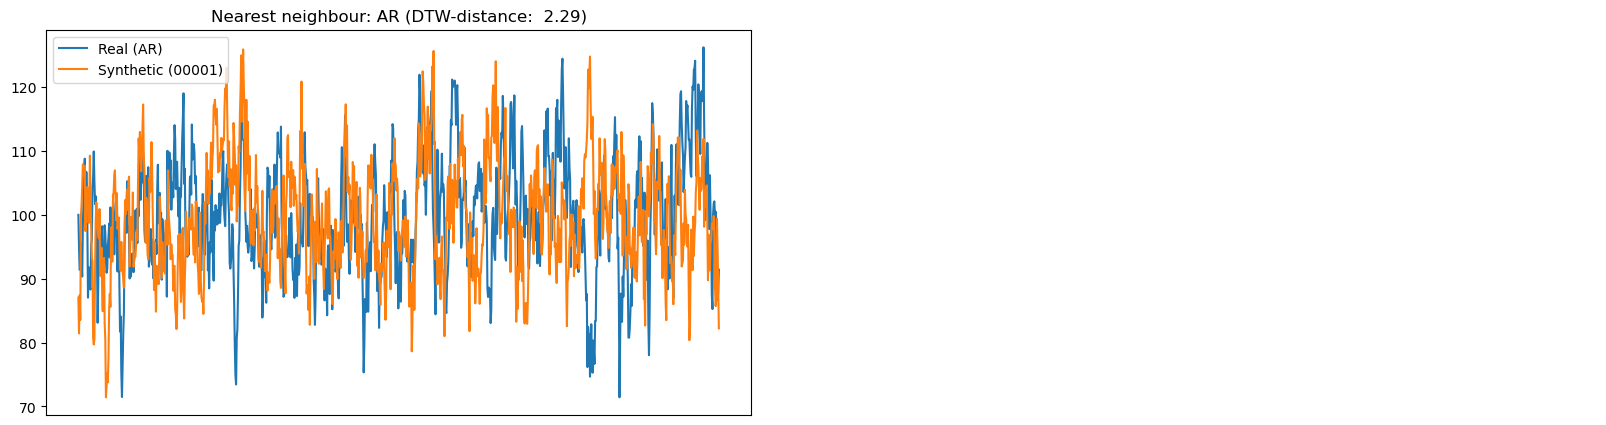

In [30]:
ar_synth = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="AR", n_epochs = 1000, n_samples = 5, verbose = True)

**Comment:** As expected the PAR is able to model AR processes very well, the higher the autocorrelation coefficient $\phi$ the better it is.

### Constant

Epoch 1000 | Loss -2159.60302734375: 100%|██████████| 1000/1000 [02:43<00:00,  6.10it/s]
100%|██████████| 5/5 [00:32<00:00,  6.55s/it]


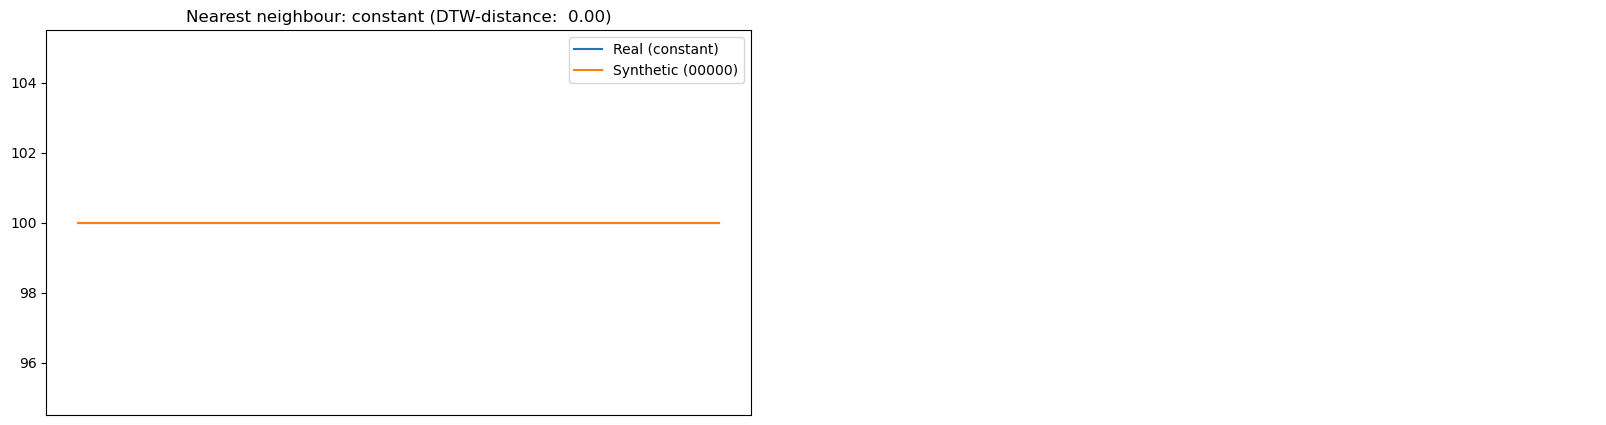

In [31]:
constant = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="constant", n_epochs = 1000, n_samples = 5, verbose = True)

**Comment:** With constant TS, the PAR model is "too perfect". That means that privacy will be compromised !

### Square

Epoch 1000 | Loss -2185.024169921875: 100%|██████████| 1000/1000 [02:51<00:00,  5.83it/s]
100%|██████████| 5/5 [00:32<00:00,  6.56s/it]


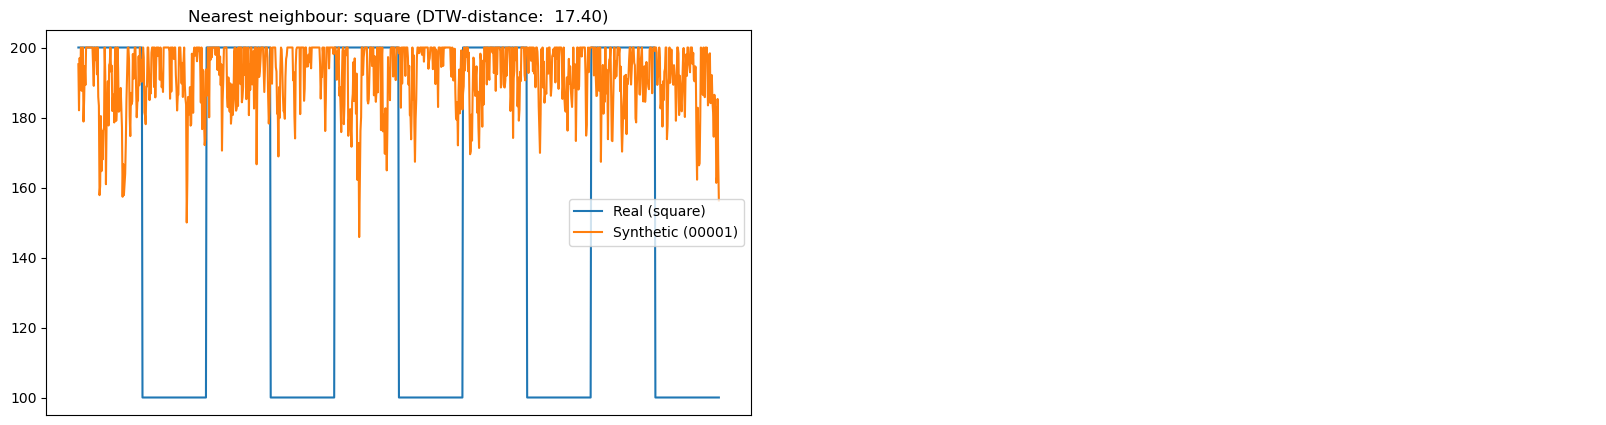

In [32]:
square = train_single_TS(df_ts_long, metadata_ts, identifier="variable", ts_name="square", n_epochs = 1000, n_samples = 5, verbose = True)

**Comment:** This is the weakness of the AR model. The PAR synthesizer is not able to model large changes between y values well. This is probably due to the AR-nature of the model, which doesn't apply to these kind of TS, where you have large drops in between "perfect AR periods".

### Conclusion from fake TS experiments

As soon as the real TS has periods where it does not follow an AR-like process, the model is not able to reproduce similar TS. In the remaining cases, it is pretty good.

## Plots for article
- Show pooled training vs. Individual training